In [22]:
import numpy as np
import librosa
from IPython.display import Audio, display
from matplotlib import pyplot as plt
import soundfile as sf
import scipy


import sys
import os
# Add upper directory
current_dir = os.path.dirname(os.path.abspath('lpa.ipynb'))
upper_dir = (os.path.join(current_dir, '..'))
sys.path.append(upper_dir)
from utils_global import draw_spec, audioshow, extract_frames, lpf, VisualizeFrames
from HW3.mystft import stft, istft, overlapadd
from mylpc import *

### Frame-Wise Linear Predictive Analysis

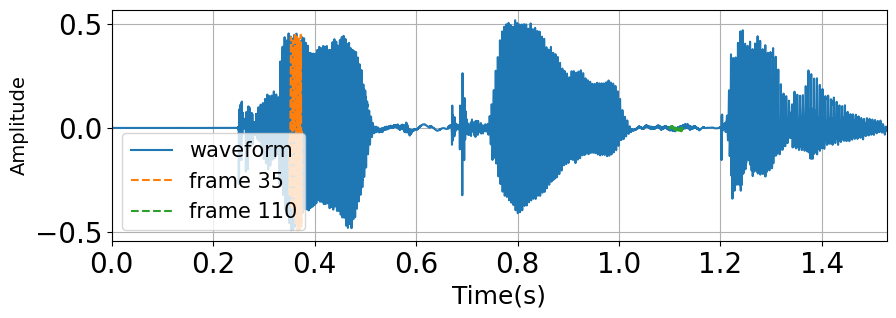

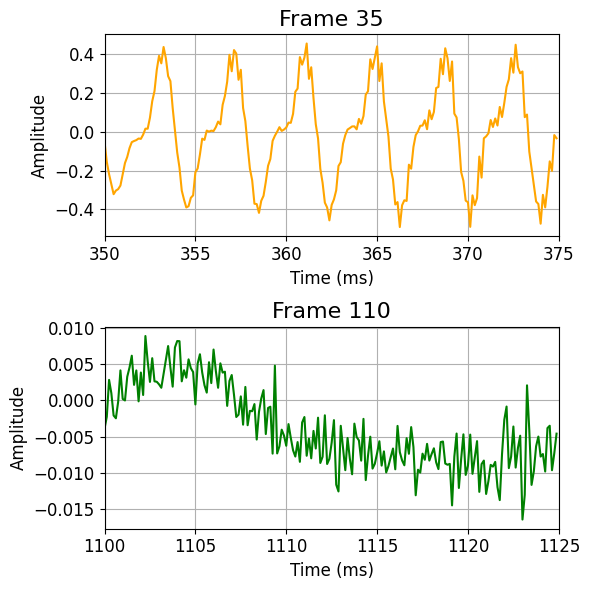

In [23]:
y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/s5_001_mic1.flac", sr=8000)
# y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/s5_180_mic1.flac", sr=8000)
# y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/sample_crop_16kHz.wav", sr=8000)
# VisualizeFrames(y, sr, win_length=200, hop_length=80, frame_indices=[5, 25], win_type="rectangular", figsize=(10,3))
frames = extract_frames(y, sr=8000, win_type='rectangular', win_length=200, hop_length=80) # 251 frames
VisualizeFrames(y, sr, win_length=200, hop_length=80, frame_indices=[35, 110], win_type="rectangular", figsize=(10,3))
display(Audio(y, rate=sr))

In [7]:
## LP Analysis in single frame
for order in [4]:
    a = librosa.lpc(y, order=order) # 1 -a1 -a2 -a3 ...
    print("Librosa.LPC original:", a)
    
    mya, err = LPC(y, order=order) # Matrix Inverse
    # drbina, e1 = ref_derbin(auto_corr(y), order=order) #Derbin's Inverse
    mydrbina, e2 = derbin(auto_corr(y), p=order) #Implemented Derbin's Algorithm

    print("librosa LPC: \t\t", -1 * a[1:5])  
    print("Matrix Inverse: \t", mya[:4])      
    # print("Derbin's Inverse: \t", drbina[:4])  
    print("myDerbin's Inverse: \t", mydrbina[:4])  

    print("LPC error: \t", err[:4])  
    # print("Derbin error: \t", e1[:4])  
    print("my error: \t", e2[:4])  

    print(np.mean(err**2))
    print('\n')

    print(len(err))
    
a = librosa.lpc(y, order=2)
b = np.hstack([[0], -1 * a[1:]])
y_hat = scipy.signal.lfilter(b, [1], y) # a1 a2 a3 ...

print(a) # 1 -a2 -a2
print(b) # a1 a2 a3 ...
c, _ = LPC(y, order=2)
print(c)

Librosa.LPC original: [ 1.         -1.009134   -0.16773388  0.00589651  0.35661128]
librosa LPC: 		 [ 1.009134    0.16773388 -0.00589651 -0.35661128]
Matrix Inverse: 	 [ 1.00914525  0.16770998 -0.00589578 -0.35659754]
myDerbin's Inverse: 	 [ 1.00914525  0.16770998 -0.00589578 -0.35659754]
LPC error: 	 [180.39175415  23.36811722  18.86583303  15.55308937]
my error: 	 [180.39175415  23.36811722  18.86583303  15.55308937]
6773.872341953395


5
[ 1.         -1.3425202   0.43895105]
[ 0.          1.34252024 -0.43895105]
[ 1.3425074  -0.43893943]


gain: 0.024911957500130723


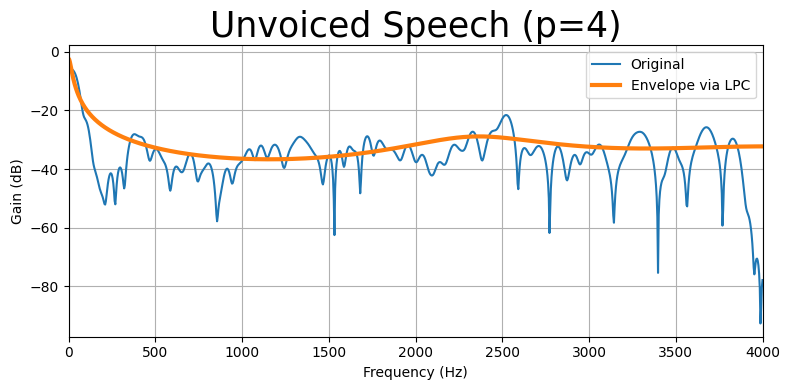

gain: 0.4398538632496165


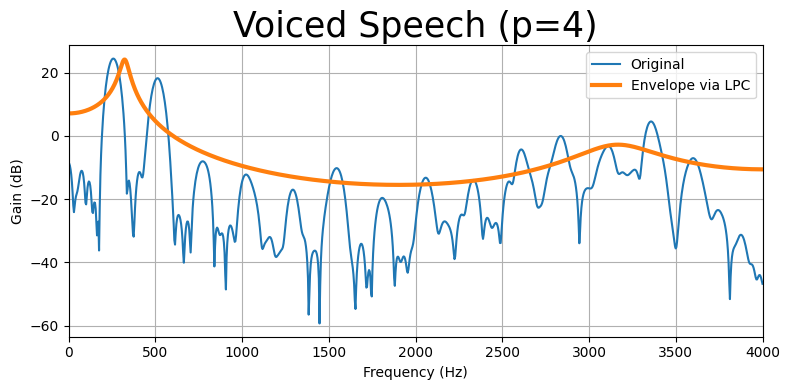

In [8]:
## Estimate of Vocal Tract using LP coefficients
frames = extract_frames(y, sr=8000, win_type='hamming', win_length=200, hop_length=80) # 251 frames
# 35 / 110 
PlotLPCSpectrum(frames[110],sr=sr,p=4,dftlen=2048, figsize=(8,4), title='Unvoiced Speech (p=4)')
# PlotLPCSpectrum(frames[110],sr=sr,p=12,dftlen=2048, figsize=(8,4), title='Unvoiced Speech (p=12)')
# PlotLPCSpectrum(frames[110],sr=sr,p=20,dftlen=2048, figsize=(8,4), title='Unvoiced Speech (p=20)')

PlotLPCSpectrum(frames[35],sr=sr,p=4,dftlen=2048, figsize=(8,4), title='Voiced Speech (p=4)')
# PlotLPCSpectrum(frames[35],sr=sr,p=12,dftlen=2048, figsize=(8,4), title='Voiced Speech (p=12)')
# PlotLPCSpectrum(frames[35],sr=sr,p=20,dftlen=2048, figsize=(8,4), title='Voiced Speech (p=20)')

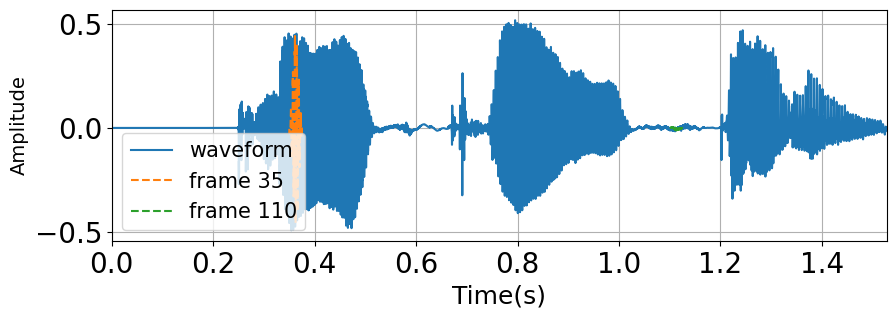

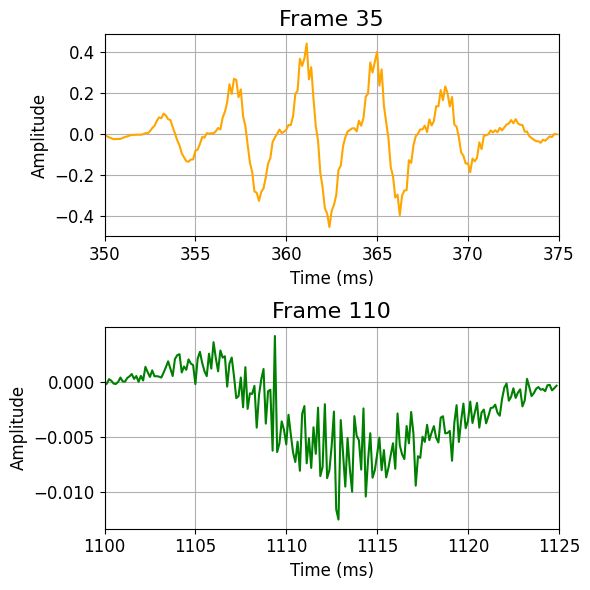

[ 0.56703263  0.85337719  0.07797359 -0.69162218]


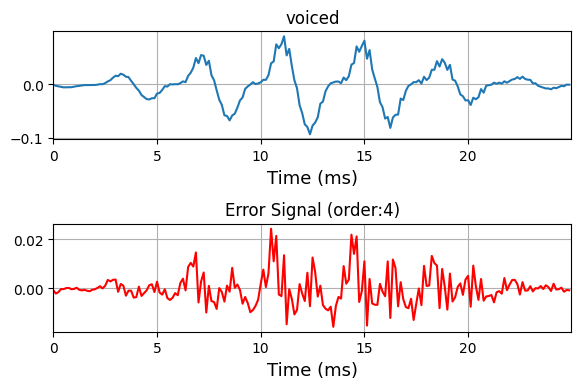

0.00867165317507173
[0.05096343 0.16658138 0.44552907 0.30411713]


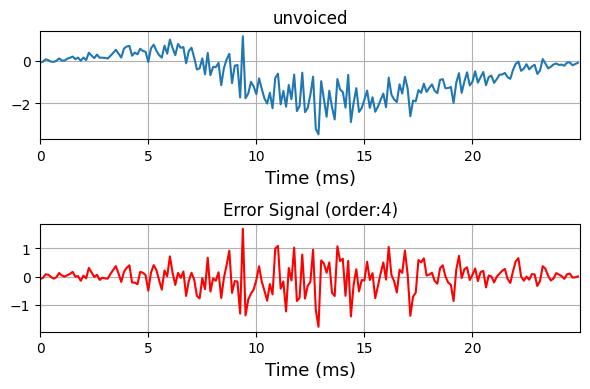

18990.627139620254


6.903401856124248

In [98]:
def PlotErrorSignal(signal, sr=16000, order=16, plot_orig=True, plot_all=True,unv=0, title=None):
    # signal = signal / np.sqrt(np.sum(signal**2))

    # LPC Analysis
    coeff,err = LPC(signal, order=order)
    print(coeff)
    coeff_T = np.concatenate(([1],-coeff))
    filtered = scipy.signal.lfilter(coeff_T,[1],signal)
    mse = np.sum(err**2)/len(err)
    
    r = auto_corr(signal)
    min_err = np.sqrt(r[0] - np.sum(coeff[:order] * r[1:order+1]))        

    if plot_all:
        plt.figure(figsize=(6, 4))
        time_ms = np.arange(len(signal)) / sr * 1000
        
        # Plot Input
        if plot_orig:
            plt.subplot(2, 1, 1)
            plt.plot(time_ms,signal, label='Input Signal')
            plt.title('Input Signal')
            if title:
                plt.title(title)
            plt.grid(True)
            plt.xlabel('Time (ms)',fontsize=13)
            plt.xlim(0,time_ms[-1]+0.1)
            # plt.ylim(-0.5, 0.5)
        # plt.legend()

        # Error Signal
        # plt.figure(figsize=(8, 6))
        plt.subplot(2, 1, 2)
        plt.plot(time_ms,filtered, label='Filtered Signal (Error Signal)',color='red')
        plt.title('Error Signal (order:{})'.format(order))
        plt.grid(True)
        # plt.legend()
        plt.xlabel('Time (ms)',fontsize=13)
        plt.xlim(0,time_ms[-1]+0.1)
        # plt.ylim(-0.15,0.15)
        plt.tight_layout()
        plt.show()

        print(mse)
    return min_err

y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/SATEST/sa0_new.wav", sr=8000)
y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/s5_001_mic1.flac", sr=8000)

frames = extract_frames(y, sr=8000, win_type='hamming', win_length=200, hop_length=80) # 251 frames
unvoiced = frames[110]
voiced = frames[35]
VisualizeFrames(y, sr, win_length=200, hop_length=80, frame_indices=[35, 110], win_type="hamming", figsize=(10,3))
PlotErrorSignal(voiced/ np.sum(voiced**2), sr=sr, order=4, title='voiced')
PlotErrorSignal(unvoiced/ np.sum(unvoiced**2), sr=sr, order=4, title='unvoiced')

# 15 35
# 35 110




### Waveform Synthesis via LPC

In [24]:
from HW3.ste_zcr import ste, zcr, vad
ste_arr = ste(frames)
zcr_arr = zcr(frames)
vad_arr = vad(ste_arr, frame_duration=15)

1200 480


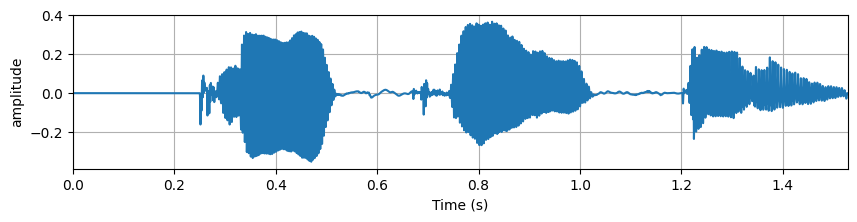

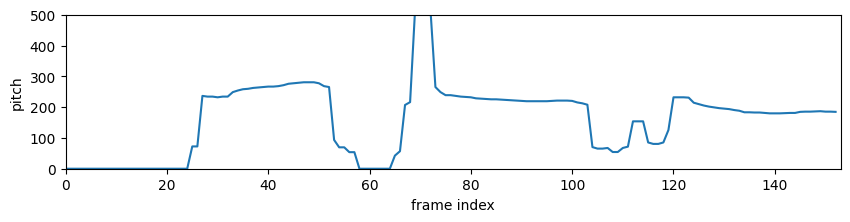

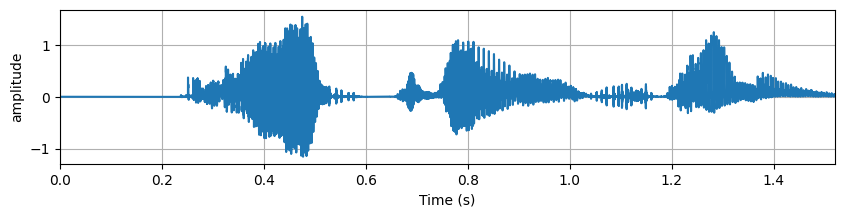

In [26]:
from HW3.pitchestimate import pitch_estimate_ac, pitch_estimate_amdf
from HW3.ste_zcr import vad

y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/sample_crop_16kHz.wav", sr=8000)
# y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/SATEST/yonseicrop.wav", sr=16000)
# y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/s5_180_mic1.flac", sr=16000)
y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/s5_001_mic1.flac", sr=48000)
display(Audio(y, rate=sr))

win_length = int(sr * 25 / 1000) # 200 - 8kHz
hop_length = int(sr * 10 / 1000) # 80 - 8kHz
print(win_length, hop_length)

################### LP Analysis
frames = extract_frames(y, sr=sr, win_type='hamming', win_length=win_length, hop_length=hop_length) # 251 frames
lpc, gain = lp_analysis(frames, 4)
lpc_2, gain_2 = lp_analysis(frames, 12)
lpc_3, gain_3 = lp_analysis(frames, 20)

################### Pitch Estimation
y_lpf = lpf(y,sr=sr, cutoff=500)
audioshow(y_lpf,sr, figsize=(10,2))
vadlist = vad(ste(frames), frame_duration=15)
pitchlist = pitch_estimate_ac(y_lpf, sr=sr, vad_arr=vadlist, win_length=win_length, hop_length=hop_length)
# pitchlist = pitch_estimate_amdf(y_lpf, sr=sr, vad_arr=vadlist, win_length=win_length, hop_length=hop_length)
pitchlist = scipy.signal.medfilt(pitchlist,kernel_size=5)
# voiced_flag, pitchlist = PitchDetector(frames, sr=sr)
plt.figure(figsize=(10,2))
plt.plot(pitchlist)
plt.ylim(0,500)
plt.ylabel('pitch')
plt.xlabel('frame index')
plt.xlim(0, len(pitchlist))

plt.show()

# audioshow(gain, sr=sr, figsize=(10,2))
###################

start=0
y = SynthesizeWaveform(lpc, gain, pitchlist, sr=sr, win_length=win_length, hop_length=hop_length, printflag=False)    
# audioshow(y[start:],sr, figsize=(10,2))
display(Audio(y[start:], rate=sr))

y = SynthesizeWaveform(lpc_2, gain_2, pitchlist, sr=sr, win_length=win_length, hop_length=hop_length)    
# audioshow(y[start:],sr, figsize=(10,2))
display(Audio(y[start:], rate=sr))

yy = SynthesizeWaveform(lpc_3, gain_3, pitchlist, sr=sr, win_length=win_length, hop_length=hop_length)    
display(Audio(yy[start:], rate=sr))

# No align
y = SynthesizeWaveform(lpc_3, gain_3, pitchlist, sr=sr, win_length=win_length, hop_length=hop_length, align_impulse=False)    
# y = overlapadd(y, win_length=win_length, hop_length=hop_length, win_type='rectangular', griffin=True)
display(Audio(y[:], rate=sr))

audioshow(y[:],sr, figsize=(10,2))


##### Gain / Impulse Align / 

### Utils